# Load Libraries

In [1]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [2]:
library(DBI)
library(ggplot2)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
mytheme <- function() {
  return(theme_bw() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              # panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
            #  axis.ticks = element_line(size=0.05),
            #  axis.ticks.length=unit("-0.05", "in"),
            #  axis.text.y = element_text(margin = margin(r = 5)),
            #  axis.text.x = element_text(hjust=1),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
             legend.title = element_blank(),
             legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mysave <- function(filename) {
  ggsave(filename, width=4, height=3, units=c("in"))
}


# Connect to DB, load data, clean data

In [4]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [5]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
update_times <- dbGetQuery(con, "
    SELECT 
    package_id,
    from_id,
    to_id,
    EXTRACT(epoch FROM (to_created - from_created)) as dt_secs
    FROM metadata_analysis.all_updates
    WHERE EXTRACT(year FROM from_created) >= 2010
")

In [6]:
update_times <- update_times %>% mutate(dt_days = dt_secs / 60 / 60 / 24)

In [7]:
update_times <- update_times %>% mutate(dt_days_int = round(dt_days))

In [8]:
update_times_full <- update_times
update_times_sample <- update_times %>% sample_n(10000)

In [9]:
100 * (update_times_full %>% filter(dt_days >= 365) %>% nrow()) / nrow(update_times_full)

[1] 1.061339

In [10]:
as.data.frame(quantile(update_times_full$dt_days, c(0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99)))

,"quantile(update_times_full$dt_days, c(0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99))"
,<dbl>
1%,7.184449e-04
5%,2.303993e-03
10%,4.783866e-03
25%,2.768513e-02
50%,9.462696e-01
75%,7.779260e+00
90%,4.012423e+01
95%,9.801989e+01
99%,3.775333e+02


In [11]:
update_times_full %>% filter(dt_days < 365) %>% nrow()

[1] 16420617

In [12]:
days_only <- update_times_full %>% select(dt_days)

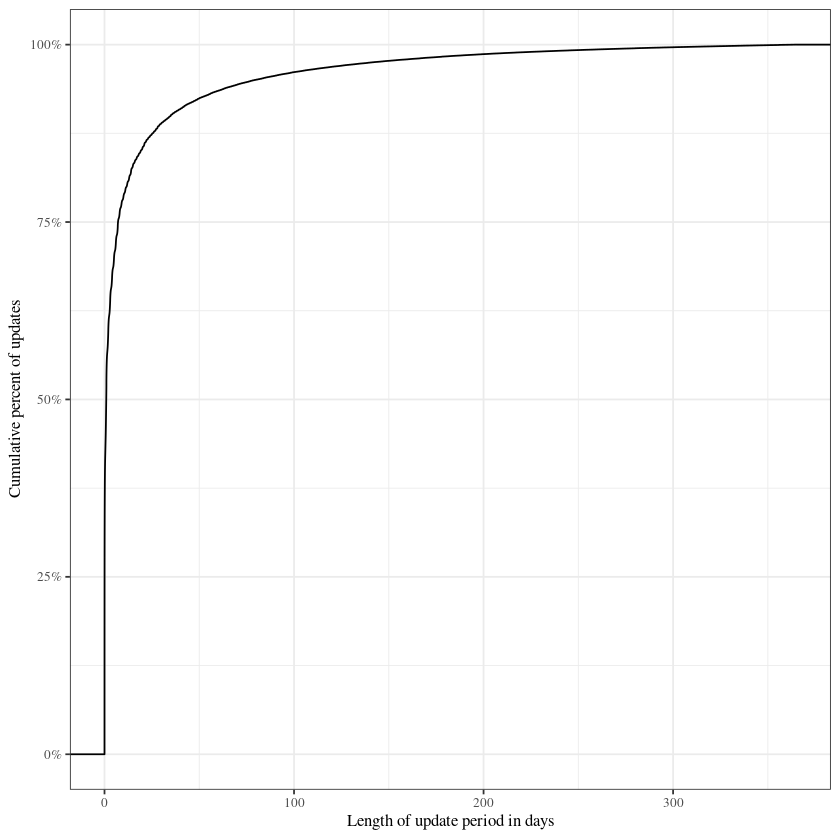

In [13]:
ggplot(data=days_only %>% filter(dt_days < 365), aes(x=dt_days)) + 
    stat_ecdf() +
    # scale_x_continuous(labels = scales::percent) +
    scale_y_continuous(labels = scales::percent) +
    xlab("Length of update period in days") +
    ylab("Cumulative percent of updates") +
    mytheme()

mysave("plots/general/update_time_ecdf.png")